In [197]:
import math
from math import sqrt, exp, log  # exp(n) == e^n, log(n) == ln(n)
import scipy.optimize as so
import numpy as np

def compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)

    theta, mu, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - exp(-2 * mu * dt)) / (2 * mu)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * exp(-mu * dt) - theta * (1 - exp(-mu * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-log(2 * math.pi) / 2) + (-log(sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood
    # since we want to maximize this total log likelihood, we need to minimize the
    #   negation of the this value (scipy doesn't support maximize)


def estimate_coefficients_MLE(X, dt, tol=1e-10):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Average Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # theta ∈ ℝ, mu > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    theta_init = np.mean(X)
    initial_guess = (theta_init, 100, 100)  # initial guesses for theta, mu, sigma
    result = so.minimize(compute_log_likelihood, initial_guess, args=(X, dt), bounds=bounds, tol=tol)
    theta, mu, sigma = result.x 
    max_log_likelihood = -result.fun  # undo negation from __compute_log_likelihood
    # .x gets the optimized parameters, .fun gets the optimized value
    return theta, mu, sigma, max_log_likelihood

In [198]:
def compute_portfolio_values(ts_A, ts_B, alloc_B):
    '''
    Compute the portfolio values over time when holding $1 of stock A 
    and -$alloc_B of stock B
    
    input: ts_A - time-series of price data of stock A,
           ts_B - time-series of price data of stock B
    outputs: Portfolio values of holding $1 of stock A and -$alloc_B of stock B
    '''
    
    ts_A = ts_A.copy()  # defensive programming
    ts_B = ts_B.copy()
    
    ts_A = ts_A / ts_A[0]
    ts_B = ts_B / ts_B[0]
    return ts_A - alloc_B * ts_B

In [199]:
def arg_max_B_alloc(ts_A, ts_B, dt):
    '''
    Finds the $ allocation ratio to stock B to maximize the log likelihood
    from the fit of portfolio values to an OU process

    input: ts_A - time-series of price data of stock A,
           ts_B - time-series of price data of stock B
           dt - time increment (1 / days(start date - end date))
    returns: θ*, µ*, σ*, B*
    '''
    
    theta = mu = sigma = alloc_B = 0
    max_log_likelihood = 0

    def compute_coefficients(x):
        portfolio_values = compute_portfolio_values(ts_A, ts_B, x)
        return estimate_coefficients_MLE(portfolio_values, dt)
    
    vectorized = np.vectorize(compute_coefficients)
    linspace = np.linspace(.01, 1, 100)
    res = vectorized(linspace)
    index = res[3].argmax()
    
    return res[0][index], res[1][index], res[2][index], linspace[index]


In [200]:
from math import sqrt, exp
import scipy.integrate as si
import scipy.optimize as so
import numpy as np

def Prime(f, x, theta, mu, sigma, r, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r) - f(x, theta, mu, sigma, r)) / h 

def Prime2(f, x, theta, mu, sigma, r, c, h=1e-5):
    # given f, estimates f'(x) using the difference quotient formula 
    # WARNING: LOWER h VALUES CAN LEAD TO WEIRD RESULTS
    return (f(x+h, theta, mu, sigma, r, c) - f(x, theta, mu, sigma, r, c)) / h 

def F(x, theta, mu, sigma, r):
    # equation 3.3
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (x-theta)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def G(x, theta, mu, sigma, r):
    # equation 3.4
    def integrand(u):
        return u**(r/mu - 1) * exp(sqrt(2*mu / sigma**2) * (theta-x)*u - u**2/2)
    return si.quad(integrand, 0, np.inf)[0]

def b_star(theta, mu, sigma, r, c):
    # estimates b* using equation 4.3
    # def opt_func(b):
    #     # equation 4.3 in the paper with terms moved to one side
    #     return abs(F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r))
    # bounds = ((.01, .99),)
    # result = so.minimize(opt_func, .5, bounds=bounds)

    b_space = np.linspace(0.1,0.9, 801)
    def func(b):
        return F(b, theta, mu, sigma, r) - (b-c)*Prime(F, b, theta, mu, sigma, r)
    
    return so.brentq(func, 0, 1)

def V(x, theta, mu, sigma, r, c):
    # OUR SELL SIGNAL
    # equation 4.2, solution of equation posed by 2.3
    
    b_star_val = b_star(theta, mu, sigma, r, c)
    
    if x < b_star_val:
        return (b_star_val - c) * F(x, theta, mu, sigma, r) / F(b_star_val, theta, mu, sigma, r)
    else:
        return x - c

def d_star(theta, mu, sigma, r, c):
    # estimates d* using equation 4.11
  
    def func(d):
        return (G(d, theta, mu, sigma, r) * (Prime2(V, d, theta, mu, sigma, r, c) - 1)) - (Prime(G, d, theta, mu, sigma, r) * (V(d, theta, mu, sigma, r, c) - d - c))

    

    # finds the root between the interval [0, 1]
    return so.brentq(func, -0.1, +0.1)

In [201]:
import numpy as np
import pandas as pd

df = pd.read_csv("USDCHF-sigma1.0-5-10-10-10-4.csv")
df["ts"] = pd.to_datetime(df["Unnamed: 0"])
df = df.set_index("ts")


In [202]:
df = df.resample("1min").mean()

ts_A1 = df[df["Index"].notna()]
ts_A2 = ts_A1['Index']

ts_B1 = df[df["FX"].notna()]
ts_B2 = ts_A1['FX']


mins = (df.index[-1] - df.index[0]).seconds / (60)
dt1 = 1 / mins

ts_B2.tail()



/tmp/ipykernel_23677/2193820817.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample("1min").mean()


ts
2022-10-25 23:55:00    0.994729
2022-10-25 23:56:00    0.994820
2022-10-25 23:57:00    0.994813
2022-10-25 23:58:00    0.994751
2022-10-25 23:59:00    0.994891
Name: FX, dtype: float64

In [203]:
theta, mu, sigma, alloc_B = arg_max_B_alloc(ts_A2,ts_B2,dt1)

In [211]:
# theta, mu, sigma, alloc_B = (0.20419935234044176, 0.030492090124698303, 0.03975767810771347, 1.0)


(0.20419935234044176, 0.030492090124698303, 0.03975767810771347, 1.0)

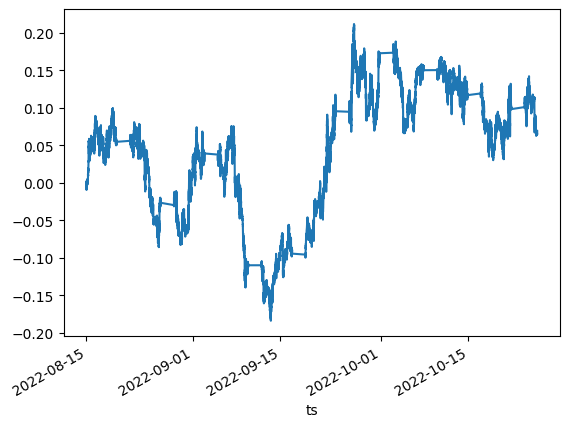

In [204]:
compute_portfolio_values(ts_A2, ts_B2, alloc_B).plot()
portfolio = compute_portfolio_values(ts_A2, ts_B2, alloc_B)



In [205]:
r=0.05
c=0.05

In [206]:
b_star(theta, mu, sigma, r, c)

0.19761848325043777

In [207]:
d_star(theta, mu, sigma, r, c)


-0.07822167995444597

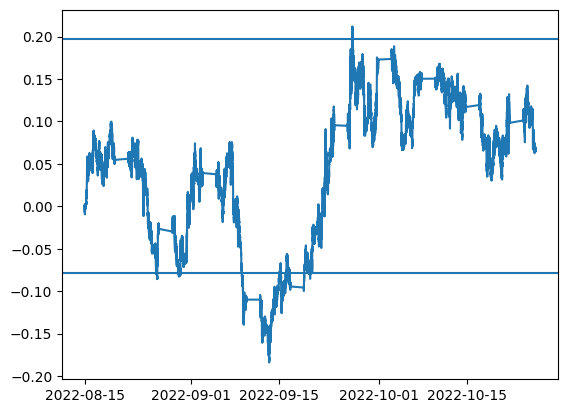

In [208]:
import matplotlib.pyplot as plt

plt.axhline(b_star(theta, mu, sigma, r, c))
plt.axhline(d_star(theta, mu, sigma, r, c))


plt.plot(compute_portfolio_values(ts_A2, ts_B2, alloc_B))

plt.show()


In [209]:
portfolio.head()

ts
2022-08-15 00:00:00    0.000000
2022-08-15 00:01:00   -0.000135
2022-08-15 00:02:00    0.000263
2022-08-15 00:03:00    0.001351
2022-08-15 00:04:00    0.001577
dtype: float64

In [238]:
df = pd.Series(portfolio)
df = df.to_frame()


df.columns = ["price"]

df["buy_sell"] = np.where((df["price"]>= b_star(theta, mu, sigma, r, c) - 0.01) & (df["price"]<= b_star(theta, mu, sigma, r, c) + 0.01)
                          , -1 ,
                           (np.where((df["price"]>= b_star(theta, mu, sigma, r, c) - 0.01) & (df["price"]<= b_star(theta, mu, sigma, r, c) + 0.01),
                                      1 ,0)))

In [241]:
df["ret"] = df["price"]*df["buy_sell"]
df


,price,buy_sell,ret
ts,,,
2022-08-15 00:00:00,0.000000,0,0.0
2022-08-15 00:01:00,-0.000135,0,-0.0
2022-08-15 00:02:00,0.000263,0,0.0
2022-08-15 00:03:00,0.001351,0,0.0
2022-08-15 00:04:00,0.001577,0,0.0
...,...,...,...
2022-10-25 23:55:00,0.066594,0,0.0
2022-10-25 23:56:00,0.067325,0,0.0
2022-10-25 23:57:00,0.067457,0,0.0
